In [1]:
%matplotlib inline
import time 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vivarium.test_util import setup_simulation, pump_simulation, TestPopulation

!date

Thu Mar  8 16:50:29 PST 2018


# Simple Disease Model

In [2]:
n_simulants = 10*1000
n_days = 365*10
t_start = pd.Timestamp('1990-01-01')

In [7]:
def build_life_table():
    max_age = 110
    max_expectency = 90
    min_expectency = 1.5
    
    ages = np.arange(0, max_age, 0.01)
    life_expectency = np.linspace(max_expectency, min_expectency, len(ages))
    
    return pd.DataFrame({'age': ages,
                         'life_expectency': life_expectency})


class SimpleMortality:
    configuration_defaults = {
            'mortality': {
                'mortality_rate': 0.01,
        },
    }

    def setup(self, builder):
        self.config = builder.configuration.mortality
        self.population_view = builder.population.get_view(columns=['alive'], query="alive == 'alive'")
        
        self.mortality_rate = builder.value.register_rate_producer(rate_name='mortality_rate',
                                                                    source=self.base_mortality_rate)
        
        builder.event.register_listener('time_step', self.on_time_step)
        self.death_emitter = builder.event.get_emitter('deaths')
    
    def base_mortality_rate(self, index):
        return pd.Series(self.config.mortality_rate, index=index)

    def on_time_step(self, event):
        effective_rate = self.mortality_rate(event.index)
        effective_probability = 1-np.exp(-effective_rate)
        
        draw = np.random.random(size=len(event.index))
        affected_simulants = event.index[draw < effective_probability]
        
        self.population_view.update(pd.Series('dead', index=affected_simulants).astype(
                                  pd.api.types.CategoricalDtype(
                                      categories=['alive', 'dead', 'untracked'], ordered=False)))
        self.death_emitter(event.split(affected_simulants))

In [8]:
class SimpleIntervention:
    
    def setup(self, builder):
        self.cumulative_cost = 0
        self.clock = builder.clock()
        
        self.population_view = builder.population.get_view(['age', 'alive'], 
                                                           query='age >= 25 and alive == "alive"')
        
        builder.event.register_listener('time_step', self.on_time_step)
        builder.event.register_listener('simulation_end', self.dump_metrics)
        
        builder.value.register_value_modifier('mortality_rate', modifier=self.mortality_rates)
        

    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        
        if event.time.year >= 1995:
            time_step = event.step_size / pd.Timedelta(days=365)
            self.cumulative_cost += 2.0 * len(pop.index) * time_step

    def mortality_rates(self, index, rates):
        if self.clock().year >= 1995:
            pop = self.population_view.get(index)
            rates.loc[pop.index] *= 0.5
        return rates

    def dump_metrics(self, event):
        print('Cost:', self.cumulative_cost)


In [9]:
class SimpleMetrics:
    def setup(self, builder):
        self.start_time = time.time()
        self.deaths = 0
        self.ylls = 0
        self.life_table = builder.lookup(build_life_table(),
                                         key_columns=(), parameter_columns=('age',))
        
        builder.event.register_listener('deaths', self.count_deaths_and_ylls)
        builder.event.register_listener('simulation_end', self.dump_metrics)

    def count_deaths_and_ylls(self, event):
        self.deaths += len(event.index)
        t = self.life_table(event.index)
        self.ylls += t.sum()    

    def dump_metrics(self, event):
        print('\nWith intervention:')
        print('Deaths:', self.deaths)
        print('YLLs:', self.ylls)
        print('Run time:', time.time() - self.start_time)

In [10]:
components = [TestPopulation(), SimpleMortality(), SimpleIntervention(), SimpleMetrics()]
simulation = setup_simulation(components, population_size=n_simulants, start=t_start)
pump_simulation(simulation, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=3650)))

Cost: 77264.4986301377

With intervention:
Deaths: 866
YLLs: Series([], dtype: float64)
Run time: 89.70576548576355


3650

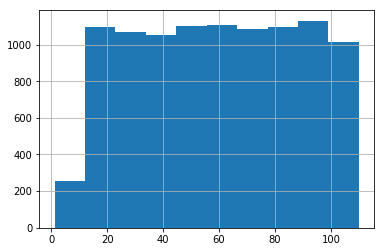

In [11]:
simulation.population.population.age.hist()

In [14]:
df = simulation.population.population
df.alive.value_counts()

alive        9180
dead          820
untracked       0
Name: alive, dtype: int64

In [15]:
cdr = (df.alive != 'alive').sum() / (n_days/365*len(df))
print('CDR = {:.1f} / 1000'.format(1000*cdr))

CDR = 8.2 / 1000
